<a href="https://colab.research.google.com/github/VihaanMotwani/Automated-Diabetic-Foot-Screening-System/blob/main/Segment_Anything_Model_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1yl3oklj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1yl3oklj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=4a2a3c9a85e366b478234d4a44f4f40a384aaf27f294270c29344e6ec4f4990d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1exx9v7p/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h_4b8939.pth

--2025-02-23 04:58:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.165.160.106, 3.165.160.70, 3.165.160.69, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.165.160.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  39.4MB/s    in 24s     

2025-02-23 04:59:23 (104 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import cv2
import numpy as np
import torch
import os
import glob
import matplotlib.pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [ ]:
model_type = "vit_h"
checkpoint_path = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
def combine_and_keep_largest(masks):
    """
    Combine all boolean masks into a single mask,
    then keep only the largest connected component.
    """
    if not masks:
        return None

    # 1. Combine (logical OR) all masks
    height, width = masks[0]["segmentation"].shape
    combined = np.zeros((height, width), dtype=np.uint8)

    for m in masks:
        # Each mask is a bool array (True=foot, False=background)
        combined |= m["segmentation"].astype(np.uint8)

    # 2. Keep only the largest connected component
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(combined, connectivity=8)
    # index 0 is the background
    if num_labels > 1:
        # Find label with the largest area (excluding background)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        final_mask = (labels == largest_label).astype(np.uint8)
    else:
        final_mask = combined

    # 3. Morphological closing to fill small holes
    kernel = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)

    return final_mask

In [ ]:
def main(image_path, output_folder):
    original = cv2.imread(image_path)
    if original is None:
        print(f"Could not read image: {image_path}")
        return

    # Convert for display in matplotlib if desired
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # 2. Generate multiple masks automatically using SAM
    # (Assumes you already initialized `mask_generator` from SAM)
    masks = mask_generator.generate(original_rgb)  # returns a list of dicts

    # 3. Combine all masks, keep the largest connected component
    final_mask = combine_and_keep_largest(masks)
    if final_mask is None:
        print("No masks were generated.")
        return

    # 4. Apply the final mask to the original image
    foot_segmented = cv2.bitwise_and(original, original, mask=final_mask)

    filename = os.path.basename(image_path)
    out_path = os.path.join(output_folder, f"seg_{filename}")
    cv2.imwrite(out_path, foot_segmented)
    print(f"Processed and saved: {out_path}")

    # 5. Display or save the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Foot Segmented (Largest Component)")
    plt.imshow(cv2.cvtColor(foot_segmented, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

Processed and saved: output/seg_1017085011-IR.jpg


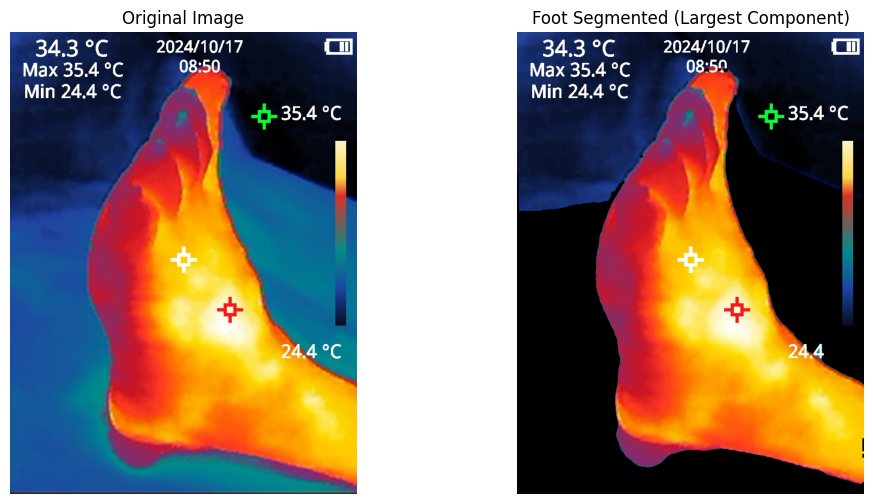

Processed and saved: output/seg_1017084959-IR.jpg


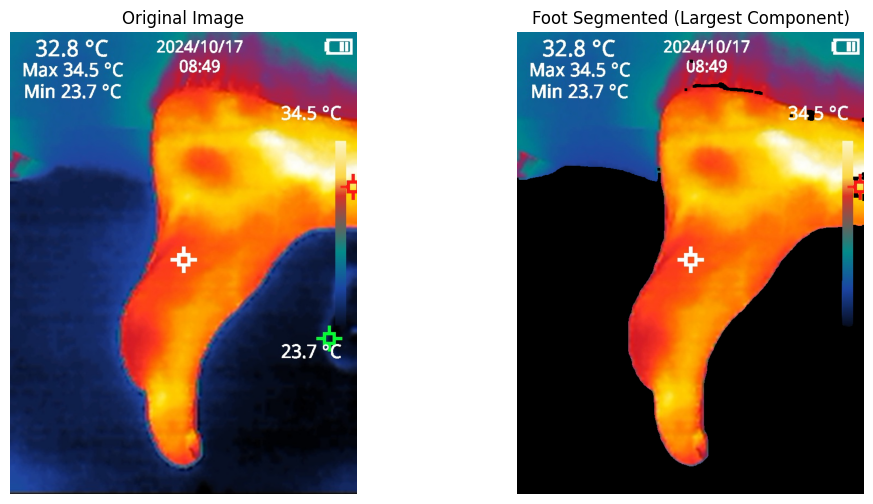

Processed and saved: output/seg_1017084940-IR.jpg


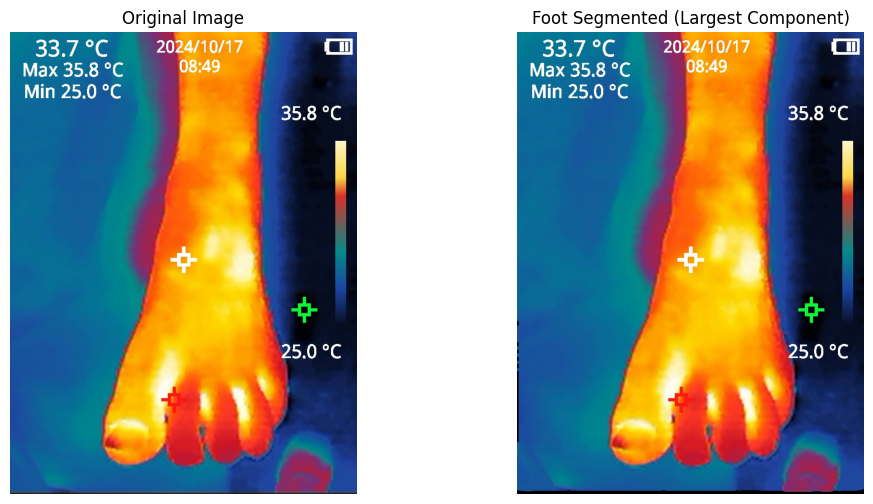

Processed and saved: output/seg_1017084927-IR.jpg


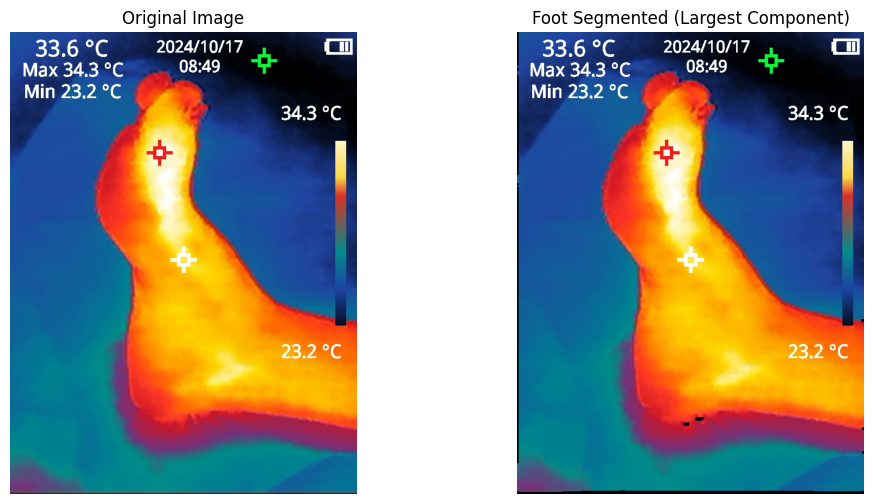

Processed and saved: output/seg_1017084836-IR.jpg


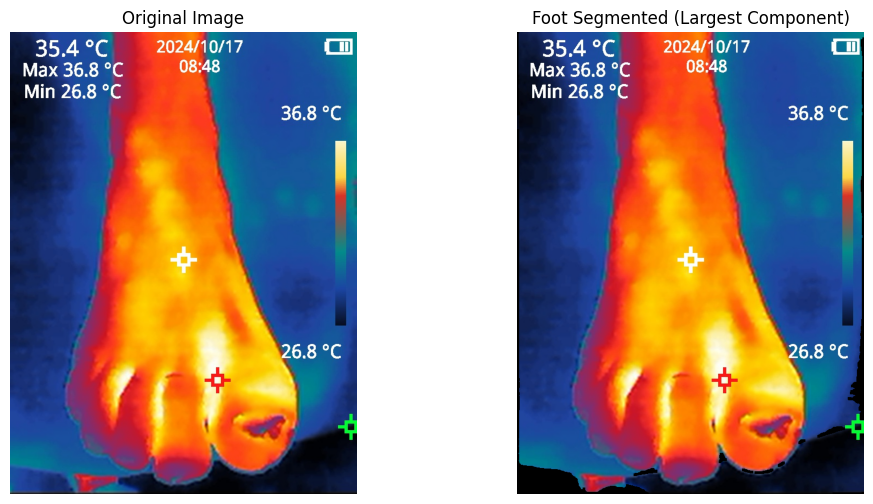

Processed and saved: output/seg_1017084917-IR.jpg


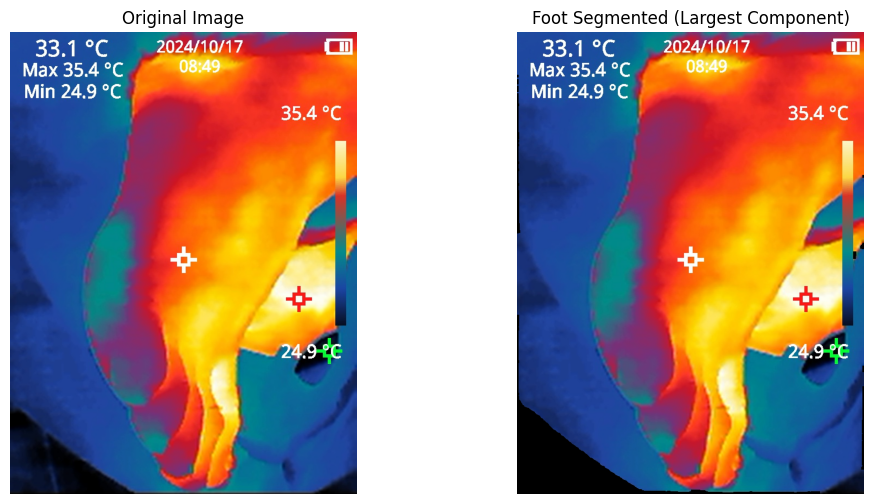

Processed and saved: output/seg_1017084950-IR.jpg


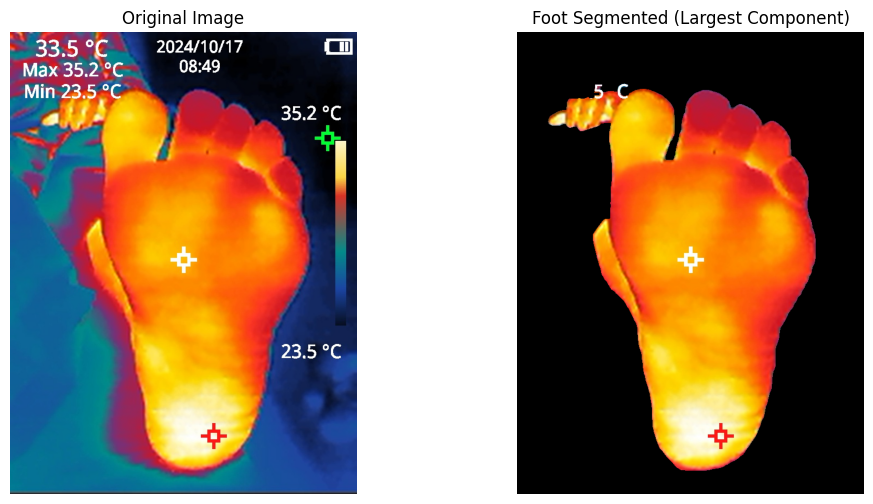

Processed and saved: output/seg_1017084827-IR.jpg


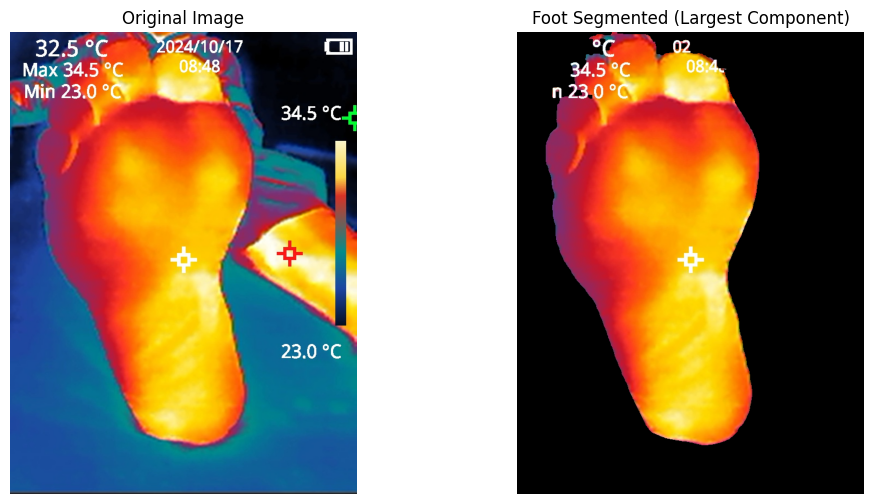

In [ ]:
input_folder = "images"
output_folder = "output"

os.makedirs(output_folder, exist_ok=True)

image_paths = glob.glob(os.path.join(input_folder, "*.jpg"))
if not image_paths:
    print(f"No JPG images found in {input_folder}")

for img_path in image_paths:
    main(img_path, output_folder)